# Lab 2

## Simulation of infectious disease spread

We will simulate infection spread using simplistic rules:
<ul>
    <li> If the person has infected neighbour, he will have a chance of getting infected, the chance being one of our parameters</li>
    <li> Each day being infected, person have chance of either dying, or getting well and gaining immunity, these two chances will be our parameters.</li>
    <li> If the person is sick for a certain amount of time(set by us) he will need an ICU, if there is none available, his mortality chance will rise drastically.</li> 
    <li> We will two scenarios: one without no seperation, and one grid being seperated into 9 segments using walls</li>
    <li> If large enough portion of our population gets sick, we will rise mortality rate, to account for shortages of basic treatment.</li>
</ul>

After simulation, we will also compare our results to a simple SIR model:
Which's implementation and description can be found [here](https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/).

## Goals:
<ul>
    <li> Simulate infectious disease spread </li>
    <li> Test whether the segmentation of population affect infectivity, mortality</li>
    </ul>
    
## Implementation:
We will define a class Person (for utility purposes, the person can also be a wall ^^), then we will create a matrix of Person objects, then we compute the upcoming state of the Person, and only then we update it, we will also track all the useful metrics about the population, such as number of infected, healthy, dead, severely ill people.

#### Important notes:
<ul>
    <li> We will forcefully infect 2 people in each segment so all the segments in the group with walls have a chance of infection.</li>
    <li> The only random initial variable is coordinates of first infections. We run both simulations(with and without walls) using same initial coordinates.</li>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import gif

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
class Person:
    # States:
    # -1 - Dead
    # 1 - Healthy
    # 2 - Infected/Infectious
    # 3 - Recovered/Immune
    # 0 - Empty/Wall
    def __init__(self, state, x, y):
        self.state = state
        self.x = x
        self.y = y
        self.next_state = state
        self.sick_days = 0
        self.ICU = False

    def is_sick_neighbour(self, grid):
        if self.x > 0 and grid[self.x - 1, self.y].state == 2:
            return True
        if self.x < grid.shape[0]-1 and grid[self.x + 1, self.y].state == 2:
            return True
        if self.y > 0 and grid[self.x, self.y - 1].state == 2:
            return True
        if self.y < grid.shape[1]-1 and grid[self.x, self.y + 1].state == 2:
            return True
        return False

    def infect(self, inf_rate, grid):
        if self.is_sick_neighbour(grid) and np.random.random() < inf_rate and self.state == 1:
            self.next_state = 2

    def recover(self, rec_rate):
        if self.state == 2 and np.random.random() < rec_rate:
            self.next_state = 3
            self.ICU = False

    def kill(self, mort_rate, ICU_available):
        if self.state == 2 and self.next_state == 2 and np.random.random() < mort_rate:
            self.next_state = -1
            self.ICU = False

        if self.state == 2 and self.ICU == True and ICU_available == False and np.random.random() < 0.5:
            self.next_state = -1
            self.ICU = False

    def update(self):
        if self.state != 0:
            self.state = self.next_state    

        if self.state == 2:
            self.sick_days += 1
        
        if self.sick_days > 31 and self.ICU == False and self.state == 2 and np.random.random() < 0.01:
            self.ICU = True

# Create a function that will create a grid of people
def create_grid(n):
    grid = np.empty((n, n), dtype=object)
    for i in range(n):
        for j in range(n):
            grid[i, j] = Person(1, i, j)
    return grid


# Create a function that will count the number of infected, recovered, dead, healthy people
def count(grid):
    infected = 0
    recovered = 0
    dead = 0
    healthy = 0
    ICU = 0
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if grid[i, j].state == 2:
                infected += 1
            elif grid[i, j].state == 3:
                recovered += 1
            elif grid[i, j].state == -1:
                dead += 1
            elif grid[i, j].state == 1:
                healthy += 1
            if grid[i, j].ICU == True:
                ICU += 1
    return infected, recovered, dead, healthy, ICU


# Create a function that will plot the grid
@gif.frame
def plot(grid, n, title):
    matrix = np.empty((n, n))
    for i in range(n):
        for j in range(n):
            matrix[i, j] = grid[i, j].state
    plt.figure(figsize=(10, 10))
    plt.title(title)
    ax = sns.heatmap(matrix, vmin=-1, vmax=3, cmap="magma", cbar=True, square=True, linewidths=0.5, linecolor="black")
    # show percentage of infected, recovered, dead, healthy people on the plot
    infected, recovered, dead, healthy, ICU = count(grid)
    all = infected + recovered + dead + healthy
    ax.text(-10, -10, f"Infected: {infected}")
    ax.text(-10, -8, f"Recovered: {recovered/all:.2%}")
    ax.text(-10, -6, f"Dead: {dead/all:.2%}")
    ax.text(-10, -4, f"Healthy: {healthy/all:.2%}")
    ax.text(-10, -2, f"ICU: {ICU}")


In [4]:
# create a function that will return true or false is there enough ICU beds
def ICU_available(grid, n):
    ICU = 0
    for i in range(n):
        for j in range(n):
            if grid[i, j].ICU == True:
                ICU += 1
    if ICU < 13:
        return True
    else:
        return False

In [5]:
# create a function that will update mortality rate based on infected people
def update_mort_rate(infected, mort_rate):
    if infected > 1000:
        mort_rate = mort_rate * 2
    return mort_rate

In [6]:
# Initial parameters:
inf_rate = 0.15 # Infection rate
rec_rate = 1/15 # Recovery rate
mort_rate = 0.0005 # Mortality rate
days = 365 # Number of days to simulate
n = 100 # Size of the grid
xs = [] # List of x coordinates of infected people
ys = [] # List of y coordinates of infected people

# Generate 18 random initial infected people, they must occupy all 9 subgrids
for i in range(2):
    x = np.random.randint(0, n//3)
    y = np.random.randint(0, n//3)
    xs.append(x)
    ys.append(y)
    x = np.random.randint(0, n//3)
    y = np.random.randint(n//3, 2*n//3)
    xs.append(x)
    ys.append(y)
    x = np.random.randint(0, n//3)
    y = np.random.randint(2*n//3, n)
    xs.append(x)
    ys.append(y)
    x = np.random.randint(n//3, 2*n//3)
    y = np.random.randint(0, n//3)
    xs.append(x)
    ys.append(y)
    x = np.random.randint(n//3, 2*n//3)
    y = np.random.randint(n//3, 2*n//3)
    xs.append(x)
    ys.append(y)
    x = np.random.randint(n//3, 2*n//3)
    y = np.random.randint(2*n//3, n)
    xs.append(x)
    ys.append(y)
    x = np.random.randint(2*n//3, n)
    y = np.random.randint(0, n//3)
    xs.append(x)
    ys.append(y)
    x = np.random.randint(2*n//3, n)
    y = np.random.randint(n//3, 2*n//3)
    xs.append(x)
    ys.append(y)
    x = np.random.randint(2*n//3, n)
    y = np.random.randint(2*n//3, n)
    xs.append(x)
    ys.append(y)

In [10]:
# A GROUP: No walls treatment

frames = []
statsA = []

# create first grid
grid = create_grid(n)

#infect random people
for x, y in zip(xs, ys):
    grid[x, y].state = 2
    grid[x, y].next_state = 2

frames.append(plot(grid, n, "Day 0"))


for a in range(days):
    print("Day " + str(a+1), end='\r')

    # grid statistics
    statsA.append(count(grid))

    curr_mort_rate = update_mort_rate(count(grid)[0], mort_rate)
    ICU_av = ICU_available(grid, n)
    for i in range(n):
        for j in range(n):
            grid[i, j].infect(inf_rate, grid)
            grid[i, j].recover(rec_rate)
            grid[i, j].kill(curr_mort_rate, ICU_av)

    # update the grid
    for i in range(n):
        for j in range(n):
            grid[i, j].update()
    frames.append(plot(grid, n, "Day " + str(a+1)))

gif.save(frames, "out.gif", duration=100)


In [11]:
# ![SegmentLocal](out.gif "segment")

In [12]:
# B GROUP: Walls treatment

frames = []
statsB = []

# create first grid
grid = create_grid(n)

#infect random people
for x, y in zip(xs, ys):
    grid[x, y].state = 2
    grid[x, y].next_state = 2


# make a cross of walls
for i in range(n):
    grid[i, 33].state = 0
    grid[33, i].state = 0

    grid[i, 66].state = 0
    grid[66, i].state = 0

frames.append(plot(grid, n, "Day 0"))


for a in range(days):
    print("Day " + str(a+1), end='\r')

    # grid statistics
    statsB.append(count(grid))
    ICU_av = ICU_available(grid, n)
    for i in range(n):
        for j in range(n):
            grid[i, j].infect(inf_rate, grid)
            grid[i, j].recover(rec_rate)
            grid[i, j].kill(mort_rate, ICU_av)

    # update the grid
    for i in range(n):
        for j in range(n):
            grid[i, j].update()
    frames.append(plot(grid, n, "Day " + str(a+1)))

gif.save(frames, "out2.gif", duration=100)


In [15]:
# ![SegmentLocal](out2.gif "segment")

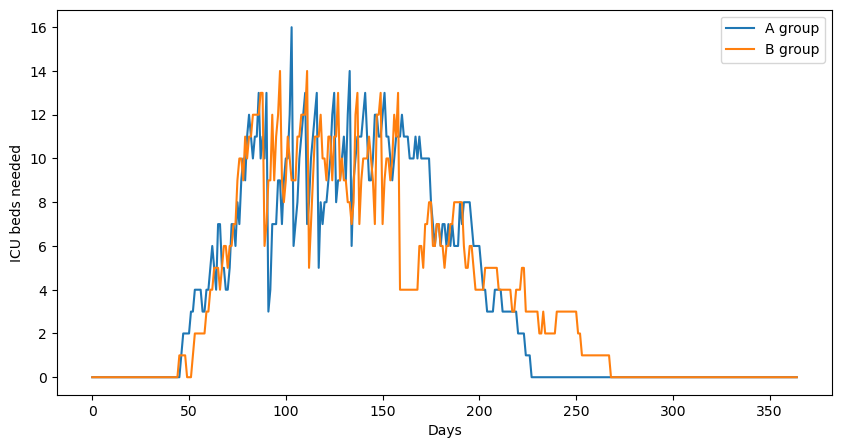

In [8]:
# Plot ICU beds availability
plt.figure(figsize=(10, 5))
plt.plot([i[4] for i in statsA], label="A group")
plt.plot([i[4] for i in statsB], label="B group")
plt.legend()
plt.xlabel("Days")
plt.ylabel("ICU beds needed")
plt.show()

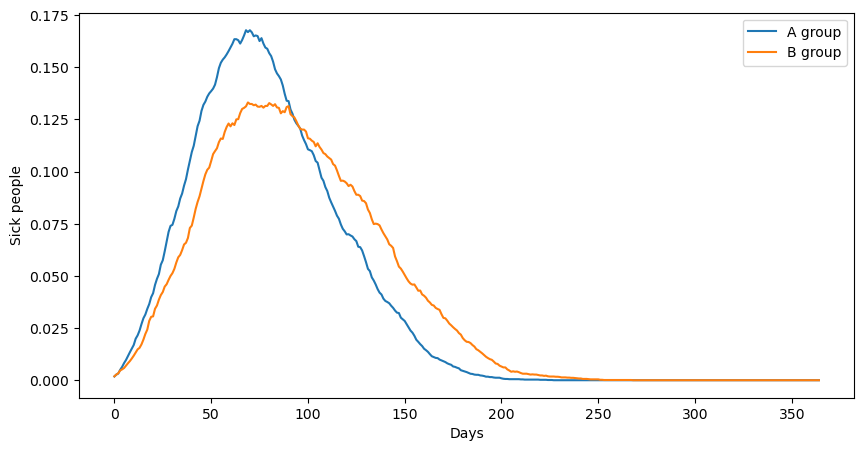

In [9]:
# convert list of tuples to np arrays
statsA = np.array(statsA)
statsB = np.array(statsB)
# plot sick people
plt.figure(figsize=(10, 5))
plt.plot([i[0]/(i[0]+i[1]+i[2]+i[3]) for i in statsA], label="A group")
plt.plot([i[0]/(i[0]+i[1]+i[2]+i[3]) for i in statsB], label="B group")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Sick people")
plt.show()

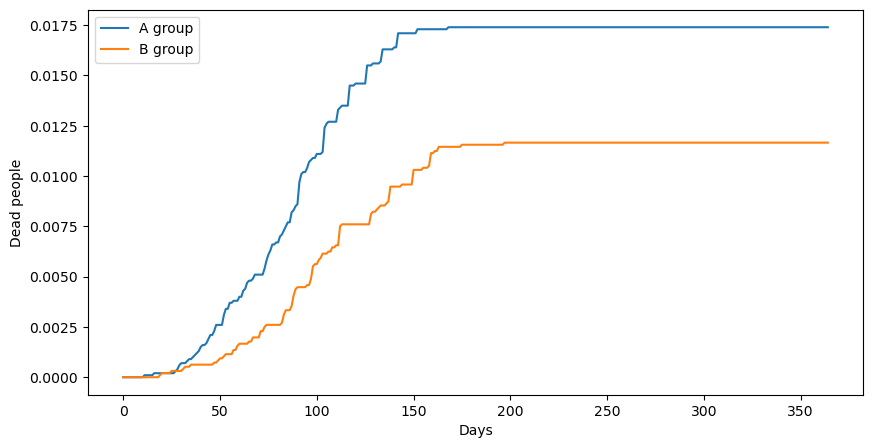

In [10]:
# plot dead people percentages
plt.figure(figsize=(10, 5))
plt.plot([i[2]/(i[0]+i[1]+i[2]+i[3]) for i in statsA], label="A group")
plt.plot([i[2]/(i[0]+i[1]+i[2]+i[3]) for i in statsB], label="B group")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Dead people")
plt.show()

In [16]:
# create a function that counts number of days each person was sick on the grid
def count_days(grid, n):
    days = []
    for i in range(n):
        for j in range(n):
            if grid[i, j].state != 0:
                days.append(grid[i, j].sick_days)
    return np.array(days)

In [17]:
count_daysA = count_days(grid, n)

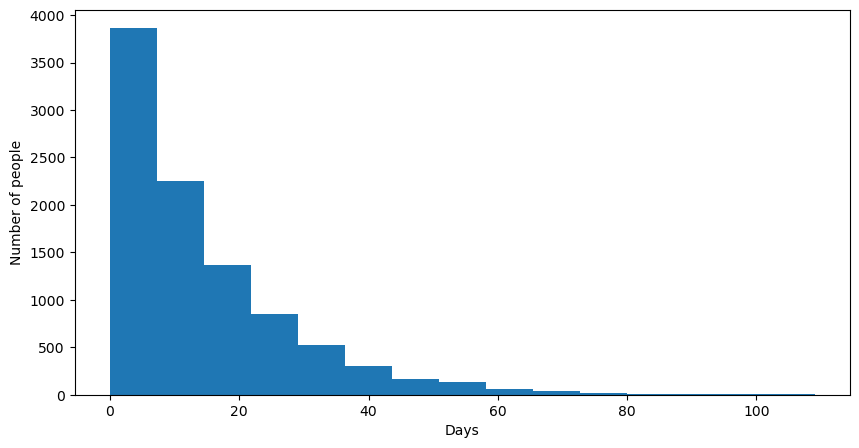

In [18]:
#plot distribution of sick days
plt.figure(figsize=(10, 5))
plt.hist(count_daysA, bins=15)
plt.xlabel("Days")
plt.ylabel("Number of people")
plt.show()

In [19]:
# get quantilse of sick days
np.quantile(count_daysA, [0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

array([ 4., 10., 20., 33., 43., 63.])

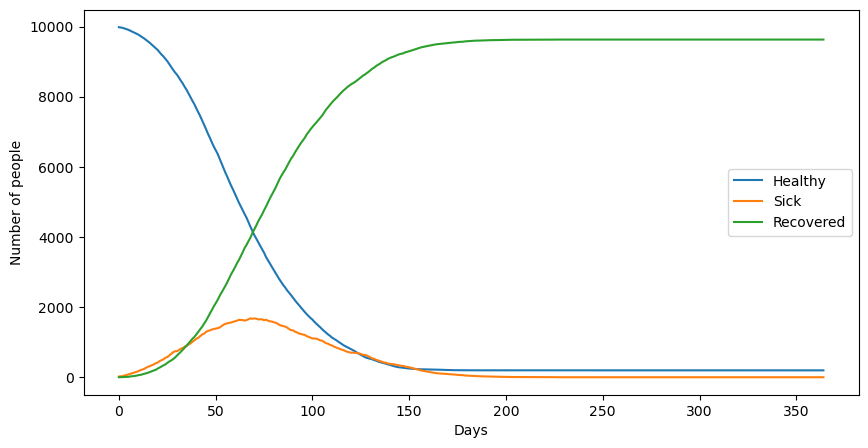

In [20]:
# plot healthy, sick, recovered
plt.figure(figsize=(10, 5))
plt.plot([i[3] for i in statsA], label="Healthy")
plt.plot([i[0] for i in statsA], label="Sick")
plt.plot([i[1] for i in statsA], label="Recovered")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Number of people")
plt.show()

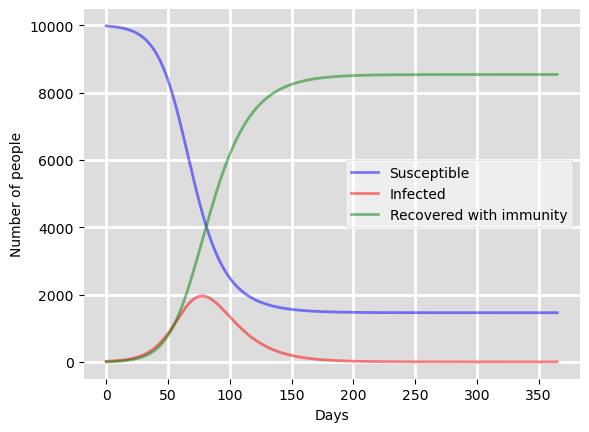

In [21]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total population, N.
N = 10000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 18, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.15, 1/15 
# A grid of time points (in days)
t = np.linspace(0, 365, 160)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Days')
ax.set_ylabel('Number of people')
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [ ]:
def get_params():
    # Initial parameters:
    inf_rate = 0.15 # Infection rate
    rec_rate = 1/15 # Recovery rate
    mort_rate = 0.0005 # Mortality rate
    days = 365 # Number of days to simulate
    n = 100 # Size of the grid
    xs = [] # List of x coordinates of infected people
    ys = [] # List of y coordinates of infected people

    # Generate 18 random initial infected people, they must occupy all 9 subgrids
    for i in range(2):
        x = np.random.randint(0, n//3)
        y = np.random.randint(0, n//3)
        xs.append(x)
        ys.append(y)
        x = np.random.randint(0, n//3)
        y = np.random.randint(n//3, 2*n//3)
        xs.append(x)
        ys.append(y)
        x = np.random.randint(0, n//3)
        y = np.random.randint(2*n//3, n)
        xs.append(x)
        ys.append(y)
        x = np.random.randint(n//3, 2*n//3)
        y = np.random.randint(0, n//3)
        xs.append(x)
        ys.append(y)
        x = np.random.randint(n//3, 2*n//3)
        y = np.random.randint(n//3, 2*n//3)
        xs.append(x)
        ys.append(y)
        x = np.random.randint(n//3, 2*n//3)
        y = np.random.randint(2*n//3, n)
        xs.append(x)
        ys.append(y)
        x = np.random.randint(2*n//3, n)
        y = np.random.randint(0, n//3)
        xs.append(x)
        ys.append(y)
        x = np.random.randint(2*n//3, n)
        y = np.random.randint(n//3, 2*n//3)
        xs.append(x)
        ys.append(y)
        x = np.random.randint(2*n//3, n)
        y = np.random.randint(2*n//3, n)
        xs.append(x)
        ys.append(y)
    return inf_rate, rec_rate, mort_rate, days, n, xs, ys

def simulate_A(params):
    inf_rate , rec_rate, mort_rate, days, n, xs, ys = params
    # A GROUP: No walls treatment

    statsA = []
    # create first grid
    grid = create_grid(n)

    #infect random people
    for x, y in zip(xs, ys):
        grid[x, y].state = 2
        grid[x, y].next_state = 2



    for a in range(days):
        #print("Day " + str(a+1), end='\r')

        # grid statistics
        statsA.append(count(grid))

        curr_mort_rate = update_mort_rate(count(grid)[0], mort_rate)
        ICU_av = ICU_available(grid, n)
        for i in range(n):
            for j in range(n):
                grid[i, j].infect(inf_rate, grid)
                grid[i, j].recover(rec_rate)
                grid[i, j].kill(curr_mort_rate, ICU_av)

        # update the grid
        for i in range(n):
            for j in range(n):
                grid[i, j].update()
    return statsA

def simulate_B(params):
    # B GROUP: Walls treatment
    statsB = []

    # create first grid
    grid = create_grid(n)

    #infect random people
    for x, y in zip(xs, ys):
        grid[x, y].state = 2
        grid[x, y].next_state = 2


    # make a cross of walls
    for i in range(n):
        grid[i, 33].state = 0
        grid[33, i].state = 0

        grid[i, 66].state = 0
        grid[66, i].state = 0



    for a in range(days):
        #print("Day " + str(a+1), end='\r')

        # grid statistics
        statsB.append(count(grid))
        ICU_av = ICU_available(grid, n)
        for i in range(n):
            for j in range(n):
                grid[i, j].infect(inf_rate, grid)
                grid[i, j].recover(rec_rate)
                grid[i, j].kill(mort_rate, ICU_av)

        # update the grid
        for i in range(n):
            for j in range(n):
                grid[i, j].update()

    return statsB


# simulate 250 times
def simulate():
    statsA = []
    statsB = []
    for i in range(250):
        print("Simulation " + str(i+1), end='\r')
        params = get_params()
        statsA.append(simulate_A(params))
        statsB.append(simulate_B(params))
    return statsA, statsB

statsA, statsB = simulate()

In [1]:
# pickle the results
import pickle
#with open('statsA.pickle', 'wb') as f:
#    pickle.dump(statsA, f)
#with open('statsB.pickle', 'wb') as f:
#    pickle.dump(statsB, f)

In [2]:
# load the results
with open('statsA.pickle', 'rb') as f:
    statsA = pickle.load(f)
with open('statsB.pickle', 'rb') as f:
    statsB = pickle.load(f)

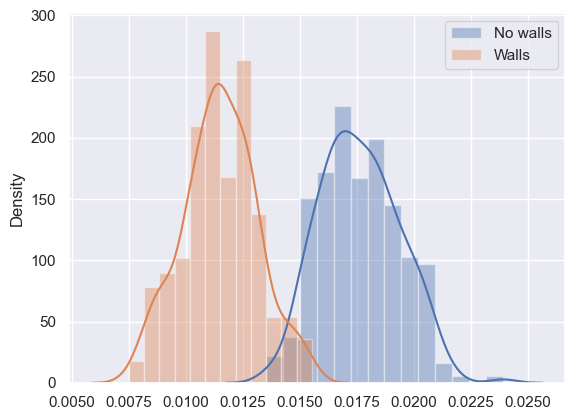

In [35]:
# plot distributions of last day deaths
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

last_day_deathsA = []
last_day_deathsB = []
# get the last day deaths percentage for each simulation
for i in range(250):
    last_day_deathsA.append(statsA[i][-1][2]/(statsA[i][-1][0]+statsA[i][-1][1]+statsA[i][-1][2]+statsA[i][-1][3]))
    last_day_deathsB.append(statsB[i][-1][2]/(statsB[i][-1][0]+statsB[i][-1][1]+statsB[i][-1][2]+statsB[i][-1][3]))

# plot the distributions
sns.distplot(last_day_deathsA, label='No walls')
sns.distplot(last_day_deathsB, label='Walls')
plt.legend()
plt.show()


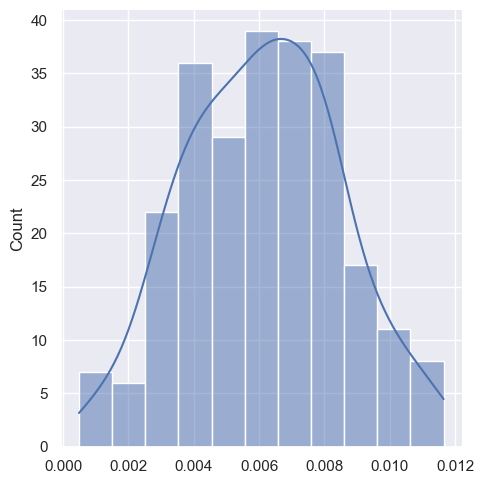

In [32]:
mort_diff = np.array(last_day_deathsA) - np.array(last_day_deathsB)
# plot distribution of difference in mortality rate
sns.displot(mort_diff, kde=True)
plt.show()

In [5]:
# test normality of mort_diff
from scipy.stats import shapiro
stat, p = shapiro(mort_diff)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.993, p=0.346
Sample looks Gaussian (fail to reject H0)


In [7]:
# test if the difference in mortality rate is significant
from scipy.stats import ttest_ind
stat, p = ttest_ind(last_day_deathsA, last_day_deathsB)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
      print('Same distributions (fail to reject H0)')
else:
      print('Different distributions (reject H0)')


Statistics=40.544, p=0.000
Different distributions (reject H0)


In [37]:
# Get 99 percent confidence interval
from scipy.stats import t
n = 250
df = n - 1
alpha = 0.01
t_critical = t.ppf(1 - alpha/2, df)
print("t-critical value:")              # Check the t-critical value
print(t_critical)
print("Degrees of Freedom:")            # Check the degrees of freedom
print(df)
print("Confidence Interval:")
CI = (np.mean(mort_diff) - t_critical*np.std(mort_diff)/np.sqrt(n), np.mean(mort_diff) + t_critical*np.std(mort_diff)/np.sqrt(n))
CI = (CI[0]*100, CI[1]*100)
# round to 2 decimal places
CI = (round(CI[0], 2), round(CI[1], 2))
print(CI)

t-critical value:
2.5957177582646316
Degrees of Freedom:
249
Confidence Interval:
(0.57, 0.65)


In [28]:
meanA = np.mean(last_day_deathsA)
mean_diff = np.mean(mort_diff)
# mean reduction of mortality rate
mean_reduction = round(100*mean_diff / meanA)
print("Mean reduction of mortality rate: " + str(mean_reduction) + "%")

Mean reduction of mortality rate: 35%
